In [51]:
import numpy as np

def tommre(R, Vcirc, sigma_R, surf_den, G = 4.299e-6):
    
    a0 = (Vcirc/R)**2
    dV = np.diff(Vcirc)
    dR = np.diff(R)
    
    Rmed  = R[:-1] + dR
    deriv = np.interp(R,Rmed,dV/dR)
    
#     plt.plot(Rmed,dV/dR, '-')
#     plt.plot(R,deriv,'-')
    
    k = 2.*a0*(1. + (R/Vcirc) *deriv )
    
#     print k
    Q = sigma_R*np.sqrt(k)/(3.36*G*surf_den)
    
    return Q 

In [53]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2
import density as den
import circular_velocity as vcirc
import numpy as np

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

vector = (1,2,4)
vector2 = ('r','M31', 'MW','r','M33')

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/'

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')

halos = (1,2,4)

for k in range(len(snapshot)-1,0,-1):

    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[k])+'.h5py', 'r')
    
    for i in halos:
        cm   = snap['subhalo_00'+ str('%s' %i)+ '/Center'][()]
        r200 = snap['subhalo_00'+ str('%s' %i)+ '/R200'][()]
        time = snap['subhalo_00'+ str('%s' %i)+ '/Time'][()]
        h    = snap['subhalo_00'+ str('%s' %i)+ '/h'][()]
        aexp = snap['subhalo_00'+ str('%s' %i)+ '/aexp'][()]

        pstr = snap['subhalo_00'+ str('%s' %i) + '/Str/Coordinates'][()]
        mstr = snap['subhalo_00'+ str('%s' %i) + '/Str/Masses'][()]
        vel  = snap['subhalo_00'+ str('%s' %i)+ '/Str/Velocities'][()]

        pdrk = snap['subhalo_00'+ str('%s' %i) + '/Drk/Coordinates'][()]
        mdrk = snap['subhalo_00'+ str('%s' %i) + '/Drk/Masses'][()]

        pgas = snap['subhalo_00'+ str('%s' %i) + '/Gas/Coordinates'][()]
        mgas = snap['subhalo_00'+ str('%s' %i) + '/Gas/Masses'][()]

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        xdrk = pdrk[:,0]-cm[0]
        ydrk = pdrk[:,1]-cm[1]
        zdrk = pdrk[:,2]-cm[2]

        xgas = pgas[:,0]-cm[0]
        ygas = pgas[:,1]-cm[1]
        zgas = pgas[:,2]-cm[2]
    #----------------------masas----------------------------
        rgal=0.15*r200*aexp

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])


        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r50 = r_sort[cincuenta][-1]
    #         M90 = Mc_str[noventa]                

    #-------------------------------------------------------------------            
        veloc,=np.where(r<r50)

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*vel[veloc,0])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*vel[veloc,1])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*vel[veloc,2])/sum(mstr[veloc])


    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        rn = np.sqrt(xn**2 + yn**2 + zn**2)

    #----------calculamos las dispersiones de velocidades---------------------
        corte1, = np.where(rn < r200)
        #     corte_bin2, = np.where(rn < 6.)

        R = np.sqrt(xn[corte1]**2 + yn[corte1]**2)

        nbin = 100 #20
        rbin, nodos = bines2.rbin1(R, nbin)

        Vr = (xn[corte1]*vxn[corte1] + yn[corte1]*vyn[corte1])/R
        Vz = vzn[corte1]
        Vt = (xn[corte1]*vyn[corte1] - yn[corte1]*vxn[corte1])/R

        sigma_z = np.zeros(nbin)
        sigma_R = np.zeros(nbin)
        sigma_t = np.zeros(nbin)


        for j in range(nbin):
            mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
            n = len(mask)
            Vz_mean = np.mean(Vz[mask])
            Vr_mean = np.mean(Vr[mask])
            Vt_mean = np.mean(Vt[mask])

            sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
            sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
            sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)


        surf_den, rden = den.surf_density(R,mstr[corte1],nbin)

        xngas = e1x*xgas + e1y*ygas + e1z*zgas
        yngas = e2x*xgas + e2y*ygas + e2z*zgas
        zngas = e3x*xgas + e3y*ygas + e3z*zgas
        rgas  = np.sqrt(xngas**2 + yngas**2 + zngas**2)

        xndrk = e1x*xdrk + e1y*ydrk + e1z*zdrk
        yndrk = e2x*xdrk + e2y*ydrk + e2z*zdrk
        zndrk = e3x*xdrk + e3y*ydrk + e3z*zdrk
        rdrk  = np.sqrt(xndrk**2 + yndrk**2 + zndrk**2)

        corte_gas = np.where(rgas < r200)
        corte_drk = np.where(rdrk < r200)

        rtot= np.concatenate([rn[corte1], rgas[corte_gas], rdrk[corte_drk]])
        mtot= np.concatenate([mstr[corte1], mgas[corte_gas], mdrk[corte_drk]])

        vc, r_vc = vcirc.Vc_bin(rtot, mtot, nbin)

        Q = tommre(rbin, vc, sigma_R, surf_den)

        data = np.ndarray([nbin,7])
        data[:,0] = rbin
        data[:,1] = sigma_z
        data[:,2] = sigma_R
        data[:,3] = sigma_t
        data[:,4] = surf_den
        data[:,5] = vc
        data[:,6] = Q

        np.savetxt(path2 + str('%s'%vector2[i])+'GS_'+str('%s'%snapshot[k])+'_toomre.dat',data, fmt='%12.6f')

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in divide


In [28]:
import h5py
import numpy as np
path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/'

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
n = len(range(len(snapshot)-1,0,-1))

time = np.zeros(n)
snapp = np.zeros(n)
i=0
for j in range(len(snapshot)-1,0,-1):

    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    snapp[i] =snapshot[j]
    time[i] = snap['subhalo_001/Time'][()]
    i += 1
    
data = np.ndarray([n,2])
data[:,0] = snapp
data[:,1] = time

np.savetxt(path2 + 'SNAP_GS_toomre.dat',data, fmt='%12.6f')

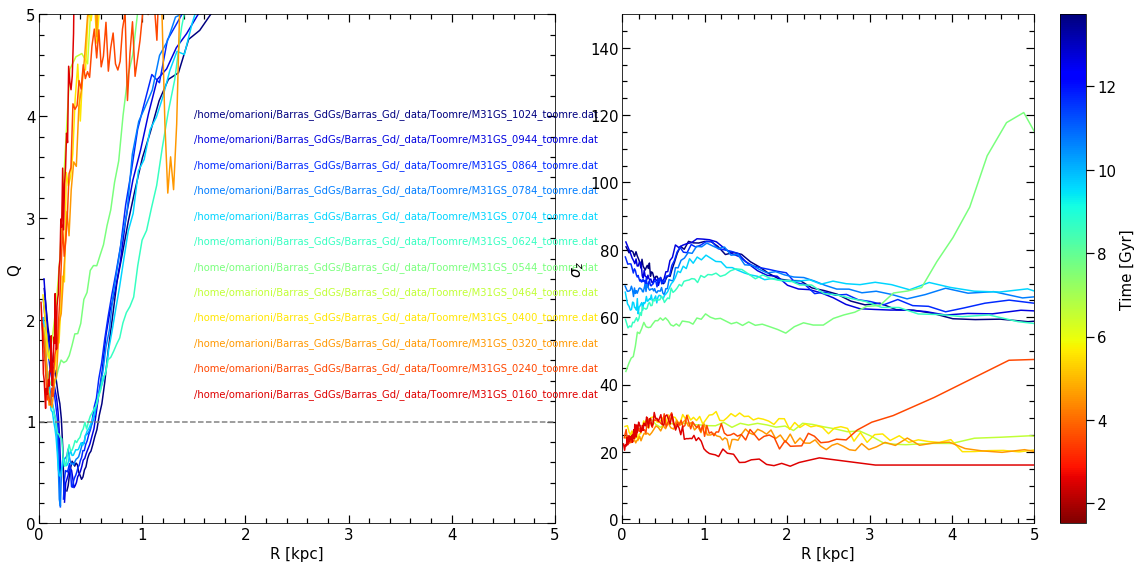

In [56]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

path= '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/'

list_of_files = glob.glob(path+'M31GS*.dat')
list_of_files = sorted(list_of_files, reverse=True)
nfiles = len(list_of_files)

time = np.loadtxt(path+'SNAP_GS_toomre.dat')[:,1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

nb = len(list_of_files[0:nfiles:5])

delta = (time[0]-time[-1])/nb
rango = np.arange(time[0],time[-1],-delta)


color_range = np.linspace(time[0],time[-1],nb)
norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
cmap1 = mpl.cm.ScalarMappable(norm = norm, cmap = 'jet_r')
cmap1.set_array(color_range)
# colors = mpl.cm.get_cmap('jet')


i=0
for file_name in list_of_files[0:nfiles:5]:
    FI = np.loadtxt(file_name)

    ax[0].plot(FI[:,0],FI[:,6], ls='-', color = cmap1.to_rgba(rango[i]))
    ax[1].plot(FI[:,0],FI[:,1], ls='-', color = cmap1.to_rgba(rango[i]))
    ax[0].text(1.5,4-i*0.25,str(file_name),color=cmap1.to_rgba(rango[i]))
    
    i += 1
    
cbar = fig.colorbar(cmap1) #, ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
cbar.set_label('Time [Gyr]',fontsize=15)
cbar.ax.tick_params( labelsize=15)
cbar.ax.tick_params(length=8, width=1.2, which='major')

#     ax.set_xscale('log')
ax[0].minorticks_on()
ax[0].tick_params( labelsize=15)
ax[0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[0].set_ylim(0,5)
ax[0].set_xlim(0,5)

ax[0].axhline(y=1,ls='--',color='gray')
ax[0].set_ylabel('Q',fontsize=15)
ax[0].set_xlabel('R [kpc]',fontsize=15)

ax[1].minorticks_on()
ax[1].tick_params( labelsize=15)
ax[1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[1].set_xlim(0,5)
ax[1].set_ylabel('$\sigma_z$',fontsize=15)
ax[1].set_xlabel('R [kpc]',fontsize=15)
#     ax.legend(fontsize=15,frameon=False)
fig.tight_layout()
plt.show()
#     fig.savefig('../_imagenes/surf_density/sd_subh_'+str('%03d'%j)+'.png',dpi=100, xxbox_inches='tight')

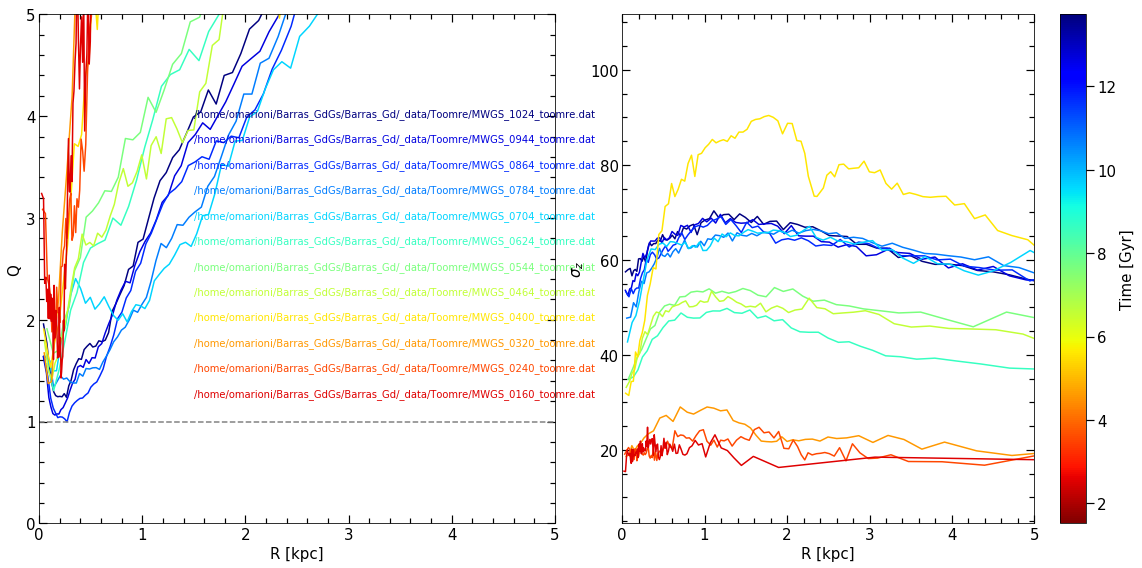

In [57]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

path= '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/'

list_of_files = glob.glob(path+'MWGS*.dat')
list_of_files = sorted(list_of_files, reverse=True)
nfiles = len(list_of_files)

time = np.loadtxt(path+'SNAP_GS_toomre.dat')[:,1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

nb = len(list_of_files[0:nfiles:5])

delta = (time[0]-time[-1])/nb
rango = np.arange(time[0],time[-1],-delta)


color_range = np.linspace(time[0],time[-1],nb)
norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
cmap1 = mpl.cm.ScalarMappable(norm = norm, cmap = 'jet_r')
cmap1.set_array(color_range)
# colors = mpl.cm.get_cmap('jet')


i=0
for file_name in list_of_files[0:nfiles:5]:
    FI = np.loadtxt(file_name)

    ax[0].plot(FI[:,0],FI[:,6], ls='-', color = cmap1.to_rgba(rango[i]))
    ax[1].plot(FI[:,0],FI[:,1], ls='-', color = cmap1.to_rgba(rango[i]))
    ax[0].text(1.5,4-i*0.25,str(file_name),color=cmap1.to_rgba(rango[i]))
    
    i += 1
    
cbar = fig.colorbar(cmap1) #, ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
cbar.set_label('Time [Gyr]',fontsize=15)
cbar.ax.tick_params( labelsize=15)
cbar.ax.tick_params(length=8, width=1.2, which='major')

#     ax.set_xscale('log')
ax[0].minorticks_on()
ax[0].tick_params( labelsize=15)
ax[0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[0].set_ylim(0,5)
ax[0].set_xlim(0,5)

ax[0].axhline(y=1,ls='--',color='gray')
ax[0].set_ylabel('Q',fontsize=15)
ax[0].set_xlabel('R [kpc]',fontsize=15)

ax[1].minorticks_on()
ax[1].tick_params( labelsize=15)
ax[1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[1].set_xlim(0,5)
ax[1].set_ylabel('$\sigma_z$',fontsize=15)
ax[1].set_xlabel('R [kpc]',fontsize=15)
#     ax.legend(fontsize=15,frameon=False)
fig.tight_layout()
plt.show()
#     fig.savefig('../_imagenes/surf_density/sd_subh_'+str('%03d'%j)+'.png',dpi=100, xxbox_inches='tight')

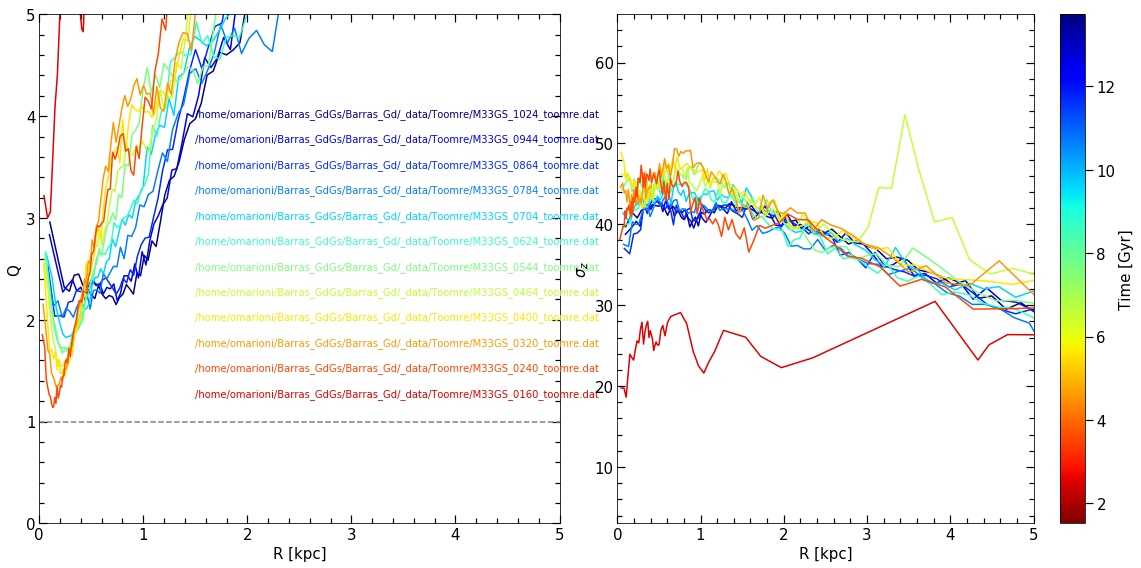

In [58]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

path= '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/'

list_of_files = glob.glob(path+'M33GS*.dat')
list_of_files = sorted(list_of_files, reverse=True)
nfiles = len(list_of_files)

time = np.loadtxt(path+'SNAP_GS_toomre.dat')[:,1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

nb = len(list_of_files[0:nfiles:5])

delta = (time[0]-time[-1])/nb
rango = np.arange(time[0],time[-1],-delta)


color_range = np.linspace(time[0],time[-1],nb)
norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
cmap1 = mpl.cm.ScalarMappable(norm = norm, cmap = 'jet_r')
cmap1.set_array(color_range)
# colors = mpl.cm.get_cmap('jet')


i=0
for file_name in list_of_files[0:nfiles:5]:
    FI = np.loadtxt(file_name)

    ax[0].plot(FI[:,0],FI[:,6], ls='-', color = cmap1.to_rgba(rango[i]))
    ax[1].plot(FI[:,0],FI[:,1], ls='-', color = cmap1.to_rgba(rango[i]))
    ax[0].text(1.5,4-i*0.25,str(file_name),color=cmap1.to_rgba(rango[i]))
    
    i += 1
    
cbar = fig.colorbar(cmap1) #, ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
cbar.set_label('Time [Gyr]',fontsize=15)
cbar.ax.tick_params( labelsize=15)
cbar.ax.tick_params(length=8, width=1.2, which='major')

#     ax.set_xscale('log')
ax[0].minorticks_on()
ax[0].tick_params( labelsize=15)
ax[0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[0].set_ylim(0,5)
ax[0].set_xlim(0,5)

ax[0].axhline(y=1,ls='--',color='gray')
ax[0].set_ylabel('Q',fontsize=15)
ax[0].set_xlabel('R [kpc]',fontsize=15)

ax[1].minorticks_on()
ax[1].tick_params( labelsize=15)
ax[1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[1].set_xlim(0,5)
ax[1].set_ylabel('$\sigma_z$',fontsize=15)
ax[1].set_xlabel('R [kpc]',fontsize=15)
#     ax.legend(fontsize=15,frameon=False)
fig.tight_layout()
plt.show()
#     fig.savefig('../_imagenes/surf_density/sd_subh_'+str('%03d'%j)+'.png',dpi=100, xxbox_inches='tight')

In [25]:
print time[-1]

8.159224
